# I. Discovery of Satellite Data Through a STAC Catalog

---
**Author(s):** Quentin Yeche, Kenji Ose, Dino Ienco - [UMR TETIS](https://umr-tetis.fr) / [INRAE](https://www.inrae.fr/)

---

## 1. Introduction

### 1.1. Satellite data access: the emergence of cloud native solutions

There are several possibilities to **discover** and **download** satellite images. In a fairly classic way, we discover and download the images on websites. If we take the example of data from the Sentinel constellation, we connect to the [SchiHub website](https://scihub.copernicus.eu/) of the Copernicus program.

However, there are other recent solutions based on new specifications. They make it possible to optimize in particular the download by targeting only the useful portions of the images.

This first notebook introduces the [STAC](https://stacspec.org/en) (SpatioTemporal Asset Catalog) specification and outlines a practical and convenient method for searching and obtaining spatiotemporal assets.

Here we will use Microsoft's Planetary Computer's STAC Python API, but STAC is meant to be a standard that other data providers can adhere to.

We will also the following topics and operations which are relevant to using a STAC Catalog:
 - GeoJSON objects
   - structure
   - displaying GeoJSON objects a map
   - calculating bounding boxes for a set of GeoJSON objects
 - Coordinate Systems

### 1.2. The STAC specification

The STAC specification actually encompasses 4 semi-independent specifications:
  1. STAC Item
  2. STAC Catalog
  3. STAC Collection
  4. (STAC API)

> **Note:** The STAC API provides specification for a RESTful endpoint (which is how the Python library `pystac` interacts with servers in the background). This is not relevant to most GIS users and falls outside the context of these notebooks.

The Item, Catalog and Collection specifications describe JSON objects with specific fields. Any JSON object that contains all the required fields for an Item (resp. Catalog, Collection) is a valid STAC Item (resp. Catalog, Collection). These JSON objects themselves do not contain any data, they store only metadata and links (more precisely URIs) to the data.

STAC Items are the smallest unit of the STAC specification. An Item represents one or several spatiotemporal assets. A STAC Catalog object is simply a group of other Catalog, Collection, and Item objects. STAC Collections are catalogs which describe a group of related items and thus they also contain dedicated metadata for those items.


## 2. Library imports

To start, we will first import several libraries that will be useful for the rest of this exercise:

- `pystac_client`: package for working with STAC Catalogs and APIs that conform to the STAC and STAC API specs in a seamless way
- `planetary_computer`: package for working with Microsoft Planetary Computer API
- `pandas`/`geopandas`: package that provides fast, flexible, and expressive (geo)data structures designed to make working with "relational" or "labeled" data both easy and intuitive
- `shapely`: package for handling geospatial vector data
- `folium`: package for visualizing spatial data via an interactive leaflet map
- `numpy`: the fundamental package for scientific computing in Python
- ... and some other tools...

In [51]:
# this cell is only useful if you're using an environment like Google Collab or
# Microsoft Planetary Computer's servers
def test_import_or_install(imports):
  import importlib
  restart_needed = False
  for import_name, pip_name in imports:
    try:
      importlib.import_module(import_name, package=None)
    except ModuleNotFoundError:
      if not restart_needed:
          restart_needed= True
          print('\033[91m' + ("ONE OR MORE LIBRARIES HAVE TO BE INSTALLED, "
          "PLEASE RESTART THE NOTEBOOK AFTER THIS CELL FINISHES EXECUTING "
          "TO ENSURE PROPER FUNCTIONALITY") + "\x1b[0m")
      %pip install {pip_name}
  if restart_needed:
    print('\033[91m' + ("LIBRARIES HAVE BEEN INSTALLED. "
          "PLEASE RESTART THE NOTEBOOK NOW ") + "\x1b[0m")

imports = [('pystac_client', 'pystac-client'),
           ('planetary_computer', 'planetary-computer')
           ]

test_import_or_install(imports)

In [52]:
# library for handling STAC data
import pystac_client

# library for acessing Microsoft Planetary Computer's STAC catalog
import planetary_computer

# dataframes and their geospatial data counterpart
import pandas as pd
import geopandas as gpd

# library for vector data
import shapely

# visualization
import folium #maps

# NumPy arrays
import numpy as np

# miscellanous
from IPython.display import display
import json
from functools import partial
from itertools import cycle

## 3. Handling GeoJSON layers

As mentioned above, STAC is fundamentally built as an extension of the GeoJSON format, hence it makes sense to first take a moment to look at this format.

### 3.1. GeoJSON structure

Here is an example of a simple GeoJSON Feature describing a rectangle Polygon: the `geometry` property and its `coordinates` sub-property are the most important, they contain the coordinates of the vertices of the polygon.

In [53]:
{
    "type": "Feature",
    "geometry": {
        'type': 'Polygon',
        'coordinates': 
            [
                [[4.825087, 43.949066],
                [4.919379, 43.949066],
                [4.919379, 43.885034],
                [4.825087, 43.885034],
                [4.825087, 43.949066]]
            ]
    }
}

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[4.825087, 43.949066],
    [4.919379, 43.949066],
    [4.919379, 43.885034],
    [4.825087, 43.885034],
    [4.825087, 43.949066]]]}}

For a slightly more elaborate, we will use a GeoJSON collection of features made up of several Polygons. In this case there are 12 rectangles corresponding to different land cover classifications around the city of Montpellier, France.

In [54]:
with open("sample.geojson") as file:
    features = json.load(file)

print(f"the geoJSON type is: {features['type']}\n")
print("Example of geoJSON strcuture for the first feature:\n")
print(json.dumps(features["features"][0], indent=4))

the geoJSON type is: FeatureCollection

Example of geoJSON strcuture for the first feature:

{
    "type": "Feature",
    "properties": {
        "fid": 1,
        "landcover": "urban01"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    3.91165161132814,
                    43.573048909505246
                ],
                [
                    3.91165161132814,
                    43.57490030924483
                ],
                [
                    3.914891560872411,
                    43.57490030924483
                ],
                [
                    3.914891560872411,
                    43.573048909505246
                ],
                [
                    3.91165161132814,
                    43.573048909505246
                ]
            ]
        ]
    }
}


> **Exercise**: Write a loop to obtain the list of land cover types.

In [55]:
# to fill
# ...
# ...

### 3.2 Displaying GeoJSON features on a map

Here, we use Folium package to display the geometries of GeoJSON features through an interactive map.

The first block of code is dedicated to some formattig settings:

In [56]:
# configuring some formatting settings for the map visuals
colors = cycle(['green', 'grey', 'orange', 'red', 'yellow', 'purple', 'pink','brown'])
style_fn = lambda x: {'color':next(colors), 'fillOpacity':0}

Here is the main part for displaying the GeoJSON features:

In [57]:
with open("sample.geojson") as file:
    features = json.load(file)

# We can use folium to easily visualize the polygons on a map
maps = folium.Map(location=[43.6085, 4.0053], zoom_start=11, control_scale=True)
polygon_group = folium.FeatureGroup(name='polygons').add_to(maps)

# these groups will only used later but it needs to be created before rendering the map
polygon_extent_group = folium.FeatureGroup(name='polygons extent', control=False).add_to(maps)
sat_extent_group = folium.FeatureGroup(name='satellite extents', control=False).add_to(maps)

maps.keep_in_front(polygon_group)
maps.add_child(polygon_group)
for feature in features['features']:
    a = folium.GeoJson(feature['geometry'], name=feature['properties']['landcover'], zoom_on_click=True)
    polygon_group.add_child(a)
folium.LayerControl().add_to(maps)

maps

### 3.3. Determining the bounding box of GeoJSON objects

Since we're dealing with multiple polygons, having an additional polygon which covers the full extent will prove useful. Here we will use `shapely` to get the bounds of a MultiPolygon object. However simply looping on each polygon and keeping track of minimums and maximums of latitude and longitude is a completely valid alternative, if a little more involved.

In [58]:
from shapely.geometry import shape, MultiPolygon, box

# create a shapely MultiPolygon from each GeoJSON polygon
union = MultiPolygon(shape(feature['geometry']) for feature in features['features'])
# create a new Polygon from the bounds of the union
extent = box(*union.bounds)

# export as a GeoJSON object
extent_geo_json = json.loads(shapely.to_geojson(extent))


fgjson = folium.GeoJson(extent_geo_json, highlight_function = lambda x: {'fillOpacity':0}, style_function = style_fn )
polygon_extent_group.add_child(fgjson)
polygon_extent_group.control = True

maps

## 4. Exploring a STAC catalog

We now want to list the Sentinel-2 images available on the previously calculated bounding box. Here, we will explore the *Microsoft Planetary Computer* catalog.

### 4.1. STAC architecture

#### 4.1.1. STAC Catalog

**STAC Catalog** can simply be seen as a directory of other STAC objects (Catalogs, Collection and Items). There are very little restrictions placed on Catalogs, the way they're organized tends to depend on the specific implementation.

<figure align="center">
  <img src="resources/stac_catalog.jpg" width="60%" alt="STAC Item diagram">
  <figcaption>STAC Collection Layout and Specification </br> Figure by <a href="https://stacspec.org/">https://stacspec.org/</a> (license <a href="https://creativecommons.org/licenses/by/4.0">CC BY 4.0</a>)
  </figcaption>
</figure>

#### 4.1.2. STAC Collection

**STAC Collections** are built upon STAC Catalogs. Collections are meant to group homogeneous data, so they include additional fields to describe the data, such as spatial and temporal extent, license and other metadata.

<figure align="center">
  <img src="https://d33wubrfki0l68.cloudfront.net/defe8206fe2240db920befa01f262e37d9036589/4f401/public/images-original/intro-images/stac-collection.png" width="60%" alt="STAC Item diagram">
  <figcaption>STAC Collection Specification </br> Figure by <a href="https://stacspec.org/">https://stacspec.org/</a> (license <a href="https://creativecommons.org/licenses/by/4.0">CC BY 4.0</a>)
  </figcaption>
</figure>

#### 4.1.3. STAC Item

**STAC Item** is built upon the [GeoJSON specification](https://geojson.org/). GeoJSON is a format for encoding different geometric data structures such as points, lines and polygons. It is widely used by standard geospatial libraries such as `Shapely`.

<figure align="center">
  <img src="https://d33wubrfki0l68.cloudfront.net/beb4a5fa5d6685adc9b8baff73647bae404c6eb6/9e0e1/public/images-original/intro-images/stac-item.jpeg" width="60%" alt="STAC Item diagram">
  <figcaption>STAC Item Specification </br> Figure by <a href="https://stacspec.org/">https://stacspec.org/</a> (license <a href="https://creativecommons.org/licenses/by/4.0">CC BY 4.0</a>)
  </figcaption>
</figure>

### 4.2. Opening Planetary Computer's STAC Catalog 

#### 4.2.1. Microsoft API connection

Let's start by opening a client object to the Planetary Computer STAC catalog.

In [59]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

> <span style='color:red'> **IMPORTANT:** The URLs that we obtain from the STAC Catalog are not valid indefinitely. They expire after about 30 minutes. If you see an error in the notebook, it is likely because the URL that you obtained by running the first few cells has now expired.</span> If that happens you should be able to just run the notebook again from the top to get a new URL. You can get longer-lasting URLs by signing up for Planetary Computer (which is free at the time of writing this notebook). More info [here](https://planetarycomputer.microsoft.com/docs/concepts/sas/). 

Most of the objects we will be using in this notebook include rich text formatting and some HTML. That means we can easily have a look at objects by using the `display` function of `IPython.display` or simply using the default output behavior of the last line of the cell in notebooks.

In [60]:
#These two next lines are equivalent
display(catalog)
catalog

<Client id=microsoft-pc>

<Client id=microsoft-pc>

Let's have a look at the contents of the `catalog` object. This particular Catalog object we have created is the parent group of all the STAC objects that Planetary Computer provides.

As a reference here is a list of the fields defined in the [STAC Catalog specification](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md).
| Element         | Type          | Description                                                  |
| --------------- | ------------- | ------------------------------------------------------------ |
| type            | string        | **REQUIRED.** Set to `Catalog` if this Catalog only implements the Catalog spec. |
| stac_version    | string        | **REQUIRED.** The STAC version the Catalog implements. |
| stac_extensions | \[string]     | A list of extension identifiers the Catalog implements.                 |
| id              | string        | **REQUIRED.** Identifier for the Catalog.                    |
| title           | string        | A short descriptive one-line title for the Catalog.          |
| description     | string        | **REQUIRED.** Detailed multi-line description to fully explain the Catalog. [CommonMark 0.29](http://commonmark.org/) syntax MAY be used for rich text representation. |
| links           | [Link Object] | **REQUIRED.** A list of references to other documents.       |

We can see that the `catalog` object does contain most of the required fields for a Catalog object. However it does not include the `stac_version` field, so it is not technically a completely valid Catalog object.

#### 4.2.2. List of collections

Now let's look at the Collection objects that are in `catalog`.

In [61]:
collections = [(collection.id, collection.title) for collection in catalog.get_collections()]
pd.set_option('display.max_rows', 150)

pd.DataFrame(collections, columns=['Collection ID', 'Collection Title'])

Collection ID  \
0                                     daymet-annual-pr   
1                                      daymet-daily-hi   
2                                        3dep-seamless   
3                                       3dep-lidar-dsm   
4                                                  fia   
5                                       sentinel-1-rtc   
6                                              gridmet   
7                                     daymet-annual-na   
8                                    daymet-monthly-na   
9                                     daymet-annual-hi   
10                                   daymet-monthly-hi   
11                                   daymet-monthly-pr   
12                                      gnatsgo-tables   
13                                                 hgb   
14                                      cop-dem-glo-30   
15                                      cop-dem-glo-90   
16                                            goes-cmi   
17                                        terraclimate   
18                                 nasa-nex-gddp-cmip6   
19                                       gpm-imerg-hhr   
20                                     gnatsgo-rasters   
21                                      3dep-lidar-hag   
22                                  io-lulc-annual-v02   
23                                            conus404   
24                                3dep-lidar-intensity   
25                            3dep-lidar-pointsourceid   
26                                                mtbs   
27                                          noaa-c-cap   
28                                     3dep-lidar-copc   
29                                      modis-64A1-061   
30                                     alos-fnf-mosaic   
31                                  3dep-lidar-returns   
32                                                mobi   
33                                       landsat-c2-l2   
34                                            era5-pds   
35                                     chloris-biomass   
36                                  kaza-hydroforecast   
37                               planet-nicfi-analytic   
38                                     modis-17A2H-061   
39                                      modis-11A2-061   
40                                     daymet-daily-pr   
41                               3dep-lidar-dtm-native   
42                           3dep-lidar-classification   
43                                      3dep-lidar-dtm   
44                                                 gap   
45                                   modis-17A2HGF-061   
46                                 planet-nicfi-visual   
47                                                gbif   
48                                   modis-17A3HGF-061   
49                                      modis-09A1-061   
50                                            alos-dem   
51                                  alos-palsar-mosaic   
52                         deltares-water-availability   
53                                    modis-16A3GF-061   
54                                      modis-21A2-061   
55                                           us-census   
56                                             jrc-gsw   
57                                     deltares-floods   
58                                      modis-43A4-061   
59                                      modis-09Q1-061   
60                                      modis-14A1-061   
61                                                hrea   
62                                      modis-13Q1-061   
63                                      modis-14A2-061   
64                                      sentinel-2-l2a   
65                                     modis-15A2H-061   
66                                      modis-11A1-061   
67                                     modis-15A3H-061   
68                                     

#### 4.2.3. Exploring a Sentinel-2 collection

In the table above we can clearly see how each collection (i.e. each row) of Planetary Computer's catalog corresponds to a dataset with common properties. Let's now look at a collection in particular:

In [62]:
#We use the collection id from the table above to obtain the collection object
catalog_s2 = catalog.get_collection('sentinel-2-l2a')
catalog_s2

<CollectionClient id=sentinel-2-l2a>

By reading the `description` field we can see that this collection contains all of the data from Sentinel-2 processed to L2A (bottom-of-atmosphere), ranging from 2016 to the present. It is obvious that looking through all this data in the same way that we did for the collections themselves would not be practical.

The simplest way to search through a catalog is to use the [`search`](https://pystac-client.readthedocs.io/en/stable/api.html#pystac_client.Client.search) method on a catalog object.
The important arguments for the search methods are the following:
  - `collections`: restricts the search to the collections which `id` were provided
  - restricting spatial extent using either:
    - `bbox` : simple bounding box given as [min(longitude), min(latitude), max(longitude), max(latitude)]
    - `intersects` : GeoJSON object, or an object implementing a `__geo_interface__` property (supported by libraries such as Shapely, ARcPy, PySAL, geojson)
  - `datetime` : using a `datetime.datetime` object or a string. For a time range you can use `'yyyy-mm-dd/yyyy-mm-dd'` (beginning/end), or even  `'2017'` as a shortcut for `'2017-01-01/2017-12-31'`, and `2017-06` for the whole month of June 2017
  - `query` : a list of JSON of query parameters. This allows to search for specific properties of items (such as cloud cover), and will be used in a later notebook

> **Note:** Finding GPS coordinates can be as simple as going to [google.com/maps](http://google.com/maps) and right clicking a point on the map. However, be careful that although standards dictate that coordinates should be given with latitude first and longitude second, some tools and libraries use longitude first and latitude second, often as a similarity to $(x,y)$ coordinates on a plane.

For now, let's reuse the extent GeoJSON Polygon we created earlier.

In [63]:
# Here longitude comes first
area_of_interest = extent_geo_json
area_of_interest

{'type': 'Polygon',
 'coordinates': [[[4.118824575734205, 43.48641456618909],
   [4.118824575734205, 43.71739887308995],
   [3.875107329166124, 43.71739887308995],
   [3.875107329166124, 43.48641456618909],
   [4.118824575734205, 43.48641456618909]]]}

The `bbox` parameter expects a Python list formatted as follows:

    [xmin, ymin, xmax, ymax]

So we have to modify `area_of_interest` in order to keep the right coordinates.


In [64]:
# Here is the equivalent bbox object to the polygon above
# using a numpy array for convenient axis operations
coords = np.array([area_of_interest['coordinates']][0][0])
bbox = [*coords.min(0), *coords.max(0)]
bbox

[3.875107329166124, 43.48641456618909, 4.118824575734205, 43.71739887308995]

Let's use the following `datetime` format:

    "start_date<yyyy-mm-dd>/end_date<yyyy-mm-dd>"

In [65]:
time_range = "2020-12-01/2020-12-31"

Now, we can search the Sentinel-2 images (i.e. *STAC Items*) that match our criteria. Here we present the two ways to pass the spatial query (`bbox` and `intersects`).

In [66]:
# the id for a collection can be found in the table we created earlier
collections = ['sentinel-2-l2a']

# As expected the GeoJSON object and
# bounding box methods give the same results
search = catalog.search(
    collections=collections,
    datetime=time_range,
    bbox=bbox
)
items = search.item_collection()
print(f"{len(items)} items found with the `bbox` parameter")

search = catalog.search(
    collections=collections,
    datetime=time_range,
    intersects=area_of_interest
)
items = search.item_collection()
print(f"{len(items)} items found with the `intersects` parameter")

12 items found with the `bbox` parameter
12 items found with the `intersects` parameter


The result of a search is an ItemCollection, which is similar to the objects we've seen previously. Thus we can look through it just the same with `display` or Jupyter's cell magic. We can then check that the results are from the right dataset (Sentinel-2 L2A), the right date ranges, and the geometry we specified falls within the specified `bbox` of each item.

In [67]:
display(items)

The results of the search are STAC Item objects. Here each Item corresponds to an acquisition of Sentinel-2. Each Item contains Assets. In our case assets are satellite images. If we look through the assets of one of the search result, we see that each band corresponds to an asset, but we also have additional assets like the Scene classification map (SCL) which attempts to classify pixels within 12 classes (including No Data, defective pixel, cloud, snow or ice, vegetation, etc.). As mentioned previously, **there is no data in an Asset object**, only a link to the data (the `href` property).

One other thing to note is the STAC Extensions section. STAC is meant to be very general and does not make many assumptions to the nature of the data it describes. This is why STAC Extensions can be created to help extend the basic scheme. The items we obtained all implement three extensions:
  - `eo` : Electro-Optical Extension Specification which helps describe data that represents a snapshot of the Earth for a single date and time
  - `sat` : Satellite Extension Specification which helps describe metadata related to a satellite
  - `projection` : Projection Extension Specification which helps describe data related to the projection of GIS data (CRS, geometry, bbox, shape, etc.)

STAC extensions can be freely created, but most are released and described at https://stac-extensions.github.io/.

> **Exercise**: search how many landsat images (collection: 'landsat-c2-l2') intersect our area of interest between 2020-12-01 and 2020-12-31.

In [68]:
# to fill
# ...
# ...


### 4.3 Coordinate systems

The GIS (Geographic Information System) field loves their acronyms. One such acronym is so ubiquitous that it is rarely explained: **CRS**. It refers to Coordinate Reference System. A CRS is a coordinate-based system used to locate geographical entities. The [EPSG registry](https://epsg.org/home.html) is a public registry of such coordinate systems. The GPS coordinates we've handled so far use are defined in a coordinate system which EPSG code is EPSG:4326. Since GPS coordinates are so widely known and available, they have become a *de facto* standard for geospatial data. In most situations, if a coordinate system is not specified it is safe to assume that coordinates are given in EPSG:4326.

> **Note:** The EPSG database specifies the order of the axis. For instance (latitude, longitude) is the order of axis for EPSG:4326, with units going up in the north and east directions. However, as mentioned previously, some libraries and programs ignore this part of the standard. They instead choose (longitude, latitude) as their default.

For Planetary Computer itself, that standard becomes crucial. Even within a collection the CRS might not be the same. For example Sentinel-2 uses the Universal Transverse Mercator (UTM) system. This system divides the Earth into 60 zones of 6° of longitude in width. Furthermore, for a same UTM zone the CRS is also different in the northern and southern hemispheres. In total, depending on the location, Sentinel-2 data uses one of 120 different CRS! In order to permit searching with a bounding box or intersects, the `bbox` field of Items uses GPS coordinates, even if the underlying data uses a different coordinate system.

### 4.4 Finding the least cloudy image

#### 4.4.1. Converting Items to GeoDataFrame

In some situations such as this one, it may be be more convenient to import the search result items into a dataframe (or table) with a library like `geopandas`. Here we see the `crs` parameter being used so that the `geopandas` knows which coordinate system is being used for the table. This would be crucial if we needed to change the coordinate system for our coordinates.

In [69]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

geometry  \
0   POLYGON ((4.00654 43.25884, 4.0181 43.29445, 4...   
1   POLYGON ((2.99975 44.25342, 4.37494 44.24514, ...   
2   POLYGON ((4.01493 43.25879, 4.01718 43.26571, ...   
3   POLYGON ((2.99975 44.25342, 4.37494 44.24514, ...   
4   POLYGON ((4.01087 43.25881, 4.03166 43.32329, ...   
5   POLYGON ((2.99975 44.25342, 4.37494 44.24514, ...   
6   POLYGON ((4.01088 43.25881, 4.02116 43.29042, ...   
7   POLYGON ((2.99975 44.25342, 4.37494 44.24514, ...   
8   POLYGON ((4.01144 43.25881, 4.04982 43.37715, ...   
9   POLYGON ((2.99975 44.25342, 4.37494 44.24514, ...   
10  POLYGON ((4.0071 43.25884, 4.04714 43.38295, 4...   
11  POLYGON ((2.99975 44.25342, 4.37494 44.24514, ...   

                       datetime     platform  proj:epsg instruments  \
0   2020-12-30T10:34:41.024000Z  Sentinel-2A      32631       [msi]   
1   2020-12-28T10:43:49.024000Z  Sentinel-2B      32631       [msi]   
2   2020-12-25T10:33:39.024000Z  Sentinel-2B      32631       [msi]   
3   2020-12-23T10:44:41.025000Z  Sentinel-2A      32631       [msi]   
4   2020-12-20T10:34:41.024000Z  Sentinel-2A      32631       [msi]   
5   2020-12-18T10:43:49.024000Z  Sentinel-2B      32631       [msi]   
6   2020-12-15T10:33:39.024000Z  Sentinel-2B      32631       [msi]   
7   2020-12-13T10:44:41.024000Z  Sentinel-2A      32631       [msi]   
8   2020-12-10T10:34:31.024000Z  Sentinel-2A      32631       [msi]   
9   2020-12-08T10:44:29.024000Z  Sentinel-2B      32631       [msi]   
10  2020-12-05T10:34:19.024000Z  Sentinel-2B      32631       [msi]   
11  2020-12-03T10:44:21.025000Z  Sentinel-2A      32631       [msi]   

   s2:mgrs_tile constellation  \
0         31TEJ    Sentinel 2   
1         31TEJ    Sentinel 2   
2         31TEJ    Sentinel 2   
3         31TEJ    Sentinel 2   
4         31TEJ    Sentinel 2   
5         31TEJ    Sentinel 2   
6         31TEJ    Sentinel 2   
7         31TEJ    Sentinel 2   
8         31TEJ    Sentinel 2   
9         31TEJ    Sentinel 2   
10        31TEJ    Sentinel 2   
11        31TEJ    Sentinel 2   

                                        s2:granule_id  eo:cloud_cover  \
0   S2A_OPER_MSI_L2A_TL_ESRI_20201231T000641_A0288...        2.613326   
1   S2B_OPER_MSI_L2A_TL_ESRI_20210113T152232_A0199...       23.009900   
2   S2B_OPER_MSI_L2A_TL_ESRI_20201225T171302_A0198...       17.763017   
3   S2A_OPER_MSI_L2A_TL_ESRI_20210104T051656_A0287...       99.561641   
4   S2A_OPER_MSI_L2A_TL_ESRI_20201220T224747_A0287...       99.968800   
5   S2B_OPER_MSI_L2A_TL_ESRI_20201219T133708_A0197...       69.449794   
6   S2B_OPER_MSI_L2A_TL_ESRI_20201216T015132_A0197...       79.774318   
7   S2A_OPER_MSI_L2A_TL_ESRI_20201214T083446_A0286...       17.230929   
8   S2A_OPER_MSI_L2A_TL_ESRI_20201220T064134_A0285...       98.454732   
9   S2B_OPER_MSI_L2A_TL_ESRI_20210105T204147_A0196...       83.895032   
10  S2B_OPER_MSI_L2A_TL_ESRI_20201206T011036_A0195...       99.636897   
11  S2A_OPER_MSI_L2A_TL_ESRI_20201204T064100_A0284...       70.190610   

                        s2:datatake_id  ... s2:cloud_shadow_percentage  \
0   GS2A_20201230T103441_028848_N02.12  ...                   1.788422   
1   GS2B_20201228T104349_019911_N02.12  ...                   2.831896   
2   GS2B_20201225T103339_019868_N02.12  ...                   5.566310   
3   GS2A_20201223T104441_028748_N02.12  ...                   0.022352   
4   GS2A_20201220T103441_028705_N02.12  ...                   0.000000   
5   GS2B_20201218T104349_019768_N02.12  ...                   0.110899   
6   GS2B_20201215T103339_019725_N02.12  ...                   0.464904   
7   GS2A_20201213T104441_028605_N02.12  ...                   4.522783   
8   GS2A_20201210T103431_028562_N02.12  ...                   0.000000   
9   GS2B_20201208T104429_019625_N02.12  ...                   1.084794   
10  GS2B_20201205T103419_019582_N02.12  ...                   0.029681   
11  GS2A_20201203T104421_028462_N02.12  ...                   1.523412   

   s2:nodata_pixel_percentage s2:unc

We can use the `geometry` property of the assets to visualize the extent of each satellite image.

In [70]:
extents = json.loads(df['geometry'].to_json())
for feature in extents['features']:
    folium.GeoJson(feature['geometry'],
                   style_function=style_fn
                   ).add_to(sat_extent_group)
sat_extent_group.control = True
maps

#### 4.4.2 Question of the Orbit

It appears that we have two different shapes of images. In fact, it appears that for some of the images the edge goes right through one of our polygons. That's an important point to note: the search matches any intersection between the area of interest and the extent, not a complete inclusion.

This is where the `sat` STAC extension can help us. Indeed if we look at the `sat:relative_orbit` we can see that there are two orbits which acquisitions overlap with our area of interest, which means two different shapes for the images.

Orbit numbers are [108   8]
Shape of orbit 108


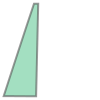

Shape of orbit 8


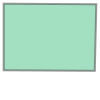

In [71]:
unique_orbits = df['sat:relative_orbit'].unique()
print(f"Orbit numbers are {unique_orbits}")

for orbit in unique_orbits:
    print(f"Shape of orbit {orbit}")
    display(df[df['sat:relative_orbit']==orbit]['geometry'].head(1).item())

We can see that the images from orbit 108 only have a very small intersection with the area of interest. So let's restrict ourselves to orbit 8.

In [72]:
items = [item for item in items if item.properties["sat:relative_orbit"]==8]

#### 4.4.3. Filtering by cloud cover

As we've seen before, the `'sentinel-2-l2a'` collection implements the `eo` extension (as indicated in the STAC extension section of the Item). This means we can use the `eo:cloud_cover` field to select the item (i.e. acquisition date) with the lowest cloudiness.

In [73]:
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
print(f"The lowest cloudiness has a value of {selected_item.properties['eo:cloud_cover']} for date {selected_item.datetime}")
selected_item

The lowest cloudiness has a value of 17.230929 for date 2020-12-13 10:44:41.024000+00:00


<Item id=S2A_MSIL2A_20201213T104441_R008_T31TEJ_20201214T083443>

#### 4.4.4. The Item's Assets

Finally let's have a look at the assets for that item we selected.

In [74]:
values = [asset.title for asset in selected_item.assets.values()]
descriptions = pd.DataFrame(values, columns=['Description'], index=pd.Series(selected_item.assets.keys(), name='asset_key'))
descriptions

Description
asset_key                                                
AOT                       Aerosol optical thickness (AOT)
B01                        Band 1 - Coastal aerosol - 60m
B02                                   Band 2 - Blue - 10m
B03                                  Band 3 - Green - 10m
B04                                    Band 4 - Red - 10m
B05                  Band 5 - Vegetation red edge 1 - 20m
B06                  Band 6 - Vegetation red edge 2 - 20m
B07                  Band 7 - Vegetation red edge 3 - 20m
B08                                    Band 8 - NIR - 10m
B09                            Band 9 - Water vapor - 60m
B11                            Band 11 - SWIR (1.6) - 20m
B12                            Band 12 - SWIR (2.2) - 20m
B8A                 Band 8A - Vegetation red edge 4 - 20m
SCL                         Scene classfication map (SCL)
WVP                                    Water vapour (WVP)
visual                                   True color image
preview                                         Thumbnail
safe-manifest                               SAFE manifest
granule-metadata                         Granule metadata
inspire-metadata                         INSPIRE metadata
product-metadata                         Product metadata
datastrip-metadata                     Datastrip metadata
tilejson                  TileJSON with default rendering
rendered_preview                         Rendered preview

The `rendered_preview` asset can prove quite useful: it is a way to quickly visualize an image without having to select each band to create a color composite. The `Image` class from `IPython.display` allows us to use a URL to display an image, and this is precisely what the `href` property of the asset contains

In [75]:
selected_item.assets["rendered_preview"].to_dict()
from IPython.display import Image
Image(url=selected_item.assets["rendered_preview"].href, width=500)

> **Exercise**: Display the least cloudy landsat image (preview).

In [76]:
# to fill
# ...
# ...
